# Imports

In [ ]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import csv
import scipy.interpolate as interp
import scipy.signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import colorsys
import math
import seaborn as sns
import pandas as pd
from scipy import stats
from itertools import combinations

#Fix a random seed for reproducibility
np.random.seed(1)

In [ ]:
def access_data(i,j):
    ## Exp No. i
    No = str(i)
    ## Exp trial. 0 is no action, 1-5 are repeating trials, each contains one ramp.
    trial = str(j)
    h5_filename = "No_"+No+"_trial_"+trial+"_sam_v3.h5"
    path = No +'/'
    mask_filename = No +'_mask.png'
    mask_name = path+mask_filename
#     print(mask_name)
#     intensity_filename = No +'_intensity.png'
#     intensity_name = path + intensity_filename
    force_filename = 'data_'+ No+'_'+trial+'.csv'
    force_name = force_filename
#     print(force_name)

    gt_x = 0
    gt_y = 0

    # if (i==22 or i==23 or i==24 or i==25):
    #     gt_x = 0
    #     gt_y = 0
    # else:
    #     with open(path+'gt.txt','r') as f:
    #         _, gt_x, gt_y = f.readline().strip().split(',')
    #         gt_x = int(gt_x)
    #         gt_y = int(gt_y)
        
    return h5_filename, mask_name, force_name, gt_x, gt_y

def read_dataset(h5_filename):
    f = h5py.File(h5_filename, 'r')
    dataset = f.get('data')
    frameCount = int(len(dataset)/nr)
    flow = dataset[:,:].reshape(-1).reshape(-1,384,512,2)
    return frameCount, flow

def read_force(force_name,fc):
    pressure = []
    with open(force_name, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if row != []:
                try:
                    pressure.append(float(row[1]))
                except:
                    continue
    # print(pressure)
    press_interp = interp.interp1d(np.arange(len(pressure)),pressure)
    press_stretch = -press_interp(np.linspace(0,len(pressure)-1,fc))
    return press_stretch

def read_mask(mask_name,ExpNo):
    mask = cv.imread(mask_name)
    mask = mask[:,:,0] # single channel image
#     intensity = cv.imread(intensity_name)
#     intensity = cv.cvtColor(intensity, cv.COLOR_BGR2GRAY)
    mask = cv.threshold(mask, 10, 255, cv.THRESH_BINARY_INV)[1]
#     cv.imwrite('binary_image.png', mask)

    intensity_map = np.zeros([1536,2048],dtype=np.uint8)
    if (ExpNo==1 or ExpNo==2 or ExpNo==3):
        intensity_center = (1132, 731) 
    elif (ExpNo == 4 or ExpNo==5 or ExpNo==6):
        intensity_center = (1134, 744)
    elif (ExpNo == 7 or ExpNo==8 or ExpNo==9):
        intensity_center = (1123, 709) 
    elif (ExpNo == 26):
        intensity_center = (1097, 739) #can
    else:
        intensity_center = (1100, 750) #trail 22~25
    radius = 450
    for r in range(1536):
        for c in range(2048):
            if np.sqrt((c-intensity_center[0])**2+(r-intensity_center[1])**2)<radius:
                intensity_map[r,c] = 255
#     cv.imwrite('binary_image2.png', intensity_map)
    mask_compact = mask[::4,::4]
    intensity_map_compact = intensity_map[::4,::4]
    mask_compact[intensity_map_compact==0]=0
    cv.imwrite('binary_image3.png', mask_compact)
    num_area = np.count_nonzero(mask_compact)
    print(num_area)
    return mask_compact, num_area

nr = 384 # H
nc = 512 # W
# frameCount = int(len(dataset)/nr)
# print(frameCount) # N 

def draw_flow(flow,yy,xx):
    h, w = 1536, 2048
    r, c = flow.shape[:2] 
    scale = 100
    mask = np.zeros((h,w,3), np.uint8)
    for iy in range(r):
        for ix in range(c):
            start_point = (xx[ix],yy[iy])
            end_point = (int(xx[ix]+scale*flow[iy][ix][0]),int(yy[iy]+scale*flow[iy][ix][1]))
            # print(start_point,end_point)
            cv.arrowedLine(mask, start_point,end_point, (0, 255, 0),5)
#     image = cv.circle(mask, (gt_x,gt_y), 5, (0, 0, 255), 3)
    cv.imwrite('flow_map.jpg', mask)

def cal_velocity(flow, dir_x, dir_y):
    flow_x = flow[:,:,0]
    flow_y = flow[:,:,1]
    # sign = np.sign(x*dir_x + y*dir_y)
    velocity = flow_x*dir_x + flow_y*dir_y
    return velocity

def cal_all_velocities(i,flow, gt_x, gt_y, mask_comp,fc):
    Lyy = np.arange(0,nr*4,4)
    Lxx = np.arange(0,nc*4,4)
    LX,LY = np.meshgrid(Lxx,Lyy)
    
    if (i==22 or i==23 or i==24 or i==25):
        dir_x = np.ones((384,512))
        dir_y = -np.ones((384,512))
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    elif (i==26 or i == 36):
        dir_x = np.zeros((384,512))
        dir_y = -np.ones((384,512))
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    else:
        dir_x = gt_x - LX
        dir_y = gt_y - LY
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))

    velocities = np.zeros([fc,nr,nc])

    for k in range(fc):
        velocities[k] = cal_velocity(flow[k],dir_x,dir_y)
        velocities[k][mask_comp==0]=0
    return velocities

def find_ending_point(gt_force):
    force_end = np.argmax(gt_force)
    return force_end

def find_starting_point(gt_force):
    force_start = (np.abs(gt_force - 0.2)).argmin()
    return force_start

def find_target_point(gt_force,target):
    force_target = (np.abs(gt_force - target)).argmin()
    return force_target

# Importing velocity maps

### read the k-th trial from a specific ExpNo, plz type in the ExpNo and trial.

In [ ]:
i = 2
ExpNo = i
trial = 1
X={}
Y={}
h5_filename, mask_name, force_name, gt_x, gt_y = access_data(i,trial)
fc, flow = read_dataset(h5_filename)
# mask_comp, num_area = read_mask(mask_name,i)
print(h5_filename)
print(force_name)

gt_force = read_force(force_name,fc)
force_end = find_ending_point(gt_force)
force_end = int(force_end)

No_2_trial_1_sam_v3.h5
data_2_1.csv


# plot quiver

In [ ]:
# the -100 is added empirically. The force has a little bit delay. no need to change.
force_start = find_starting_point(gt_force) - 100

## to use this, change the k to your desired frame, keep the window size to be 1 (since it is already good enough), keep the scale factor consistent in quiver parameters (e.g. here I use scale = 2000 all the time). Also, the quiver is already oriented correctly. The draw_flow function will save a figure to your current path, which shows vectors in green rather than black (but is not important)

In [ ]:
fvals = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]

frame_vals = []
for ff in fvals:
    frame_vals.append(find_target_point(gt_force,ff))

In [ ]:
##Save all the center locations
import torch

yy = np.arange(0,1536,64)
xx = np.arange(0,2048,64)
X, Y = np.meshgrid(xx, yy) 
flow_sparse = flow[:,::16,::16,:]
flow_cum = np.cumsum(flow_sparse, axis = 0)

xlocs = []
ylocs = []

for framenos in frame_vals:
    k = framenos
    print('************'+str(k)+'*************')
    win = 1
    x_data = np.mean(flow_cum[k:k+win,:,:,0],axis = 0)
    #     print(x_data[9:24].shape)
    y_data = np.mean(flow_cum[k:k+win,:,:,1],axis = 0)

    x_flow = x_data
    y_flow = y_data


    #Evaluate m matrix
    m = y_flow/(x_flow+1e-7)

    ##evaluate mag
    mag = np.sqrt(x_flow**2+y_flow**2)

    ##Evaluate c1 matrix
    c1 = Y-(m*X)

    denom = np.sqrt(1+m**2)

    denom_grad = torch.tensor(denom, dtype=torch.float32)
    c1_grad = torch.tensor(c1, dtype=torch.float32)
    mag_grad = torch.tensor(mag, dtype=torch.float32)
    m_grad = torch.tensor(m, dtype=torch.float32)

    # loss = MSE
    def error(x0, y0):
        c2 = y0.reshape(1,1)-(m_grad*(x0.reshape(1,1)))
        return (mag_grad*torch.abs(c1_grad-c2)/(denom_grad)).sum()

    # Training
    learning_rate = 0.01
    n_iters = 10000

    x0_ests = []
    y0_ests = []

    for zz in range(10):
        x0 = torch.tensor(np.random.randint(0,2048), dtype=torch.float32, requires_grad=True)
        y0 = torch.tensor(np.random.randint(0,1536), dtype=torch.float32, requires_grad=True)

        for epoch in range(n_iters):

            # loss
            l = error(x0, y0)

            # calculate gradients = backward pass
            l.backward()

            # update weights
            with torch.no_grad():
                x0 -= learning_rate * x0.grad
                y0 -= learning_rate * y0.grad

            # zero the gradients after updating
            x0.grad.zero_()
            y0.grad.zero_()

        #     if epoch % 10 == 0:
        #         print(f'epoch {epoch+1}: x0 = {x0.item():.3f}, y0 = {y0.item():.3f}, loss = {l.item():.8f}')

        # print(f'x0 = {x0.item():.3f}, y0 = {y0.item():.3f}, loss = {l.item():.8f}')
        
        x0_ests.append(x0.item())
        y0_ests.append(y0.item())

    print('**********')
    print(np.array(np.mean(x0_ests)))
    print(np.array(np.mean(y0_ests)))
    xlocs.append(np.array(np.mean(x0_ests)))
    ylocs.append(np.array(np.mean(y0_ests)))


************1374*************
**********
1222.487744140625
637.7622253417969
************1796*************
**********
1151.8485473632813
584.4610290527344
************2278*************
**********
1121.8082153320313
575.4842590332031
************2735*************
**********
1135.9188598632813
596.2057189941406
************3205*************
**********
1152.6441528320313
609.2182495117188
************3796*************
**********
1165.02236328125
606.5769592285156
************4157*************
**********
1064.0262084960937
493.60919799804685
************4579*************
**********
1122.1304016113281
566.1895233154297
************5001*************
**********
1123.0314636230469
562.7440063476563
************5434*************
**********
1167.0718017578124
619.3614654541016


In [ ]:
# plot the quiver
yy = np.arange(0,1536,64)
xx = np.arange(0,2048,64)
X, Y = np.meshgrid(xx, yy) 

flow_sparse = flow[:,::16,::16,:]


# the flow_cum is basically the integration!!!

flow_cum = np.cumsum(flow_sparse, axis = 0)

k = frame_vals[4]#anchor_2.5N
win = 1
x_data = np.mean(flow_cum[k:k+win,:,:,0],axis = 0)
y_data = np.mean(flow_cum[k:k+win,:,:,1],axis = 0)



# Center Location Plotting

In [ ]:
##Euc dist - Add ground truth x and y locs below
gtx = 1035
gty = 538

euc_dist = np.sqrt((np.array(xlocs)-gtx)**2+(np.array(ylocs)-gty)**2)

In [ ]:
print(euc_dist)

[212.37739006 125.74661125  94.5554648  116.50116737 137.52158288
 146.99868806  53.03832654  91.57705013  91.44290261 155.12140046]


In [ ]:
print(np.mean(euc_dist))
print(np.std(euc_dist))

122.48805841651776
41.88204028759139


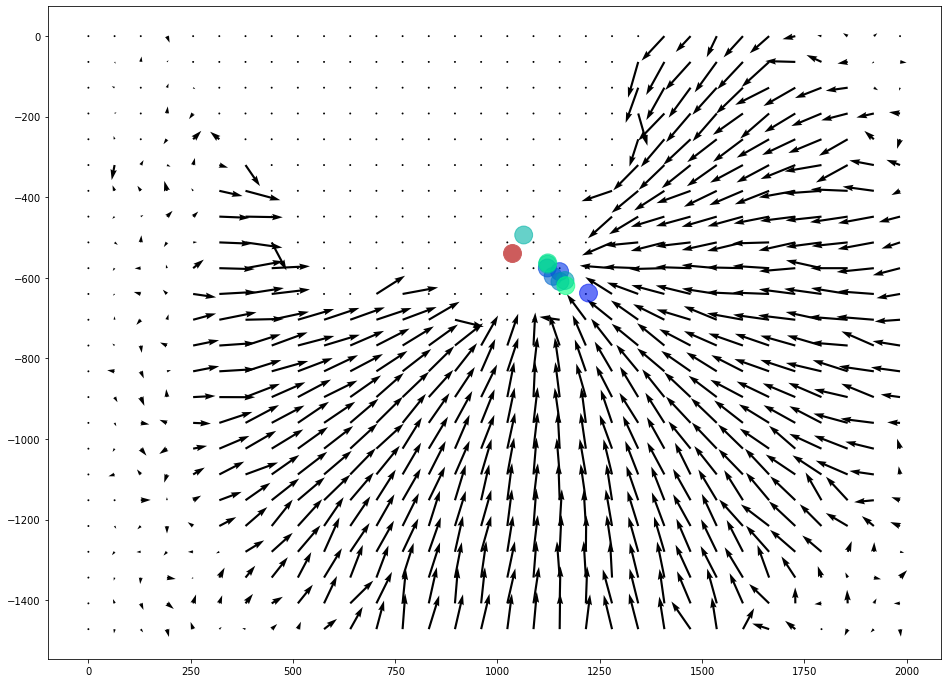

In [ ]:
##Plotting all together
#plot gt and est centers
import matplotlib as mpl

cm = plt.cm.get_cmap('winter')

def transform_vecs(u, v):
    arrow_lengths = np.sqrt(u*u + v*v) + 1e-7
    len_adjust_factor = np.log10(arrow_lengths + 1) / arrow_lengths
    return u*len_adjust_factor, v*len_adjust_factor

U2, V2 = transform_vecs(x_data, -y_data)

fig, (ax) = plt.subplots(figsize =(16, 12)) 
ax.quiver(xx,-yy, U2, V2,scale=50)

scgt = ax.scatter(gtx,-gty,c = '#CD5C5C',s=320)
sc = ax.scatter(np.array(xlocs),-np.array(ylocs),c = fvals,vmin=0, vmax=5, s=320, cmap=cm,alpha=0.6)

# plt.savefig('2_1_consol_logscale.svg')